# Segmentation networks

In the notebook will be demontsrated how to use UNet, LinkNet, FCN32 and FCN8 (realized as TFModel) to segmenation images with MNIST digits.

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append("..")
from dataset import Pipeline, B, V
from dataset.opensets import MNIST
from dataset.models.tf import FCN32, FCN16, FCN8, LinkNet, UNet, VNet, RefineNet

from multiple_mnist import MultiMNIST, demonstrate_model, get_plots
from utils import interactive_plot

Load MNIST dataset. MultiMNIST is ImagesBatch class with action that creates images with MNIST digits in random locations.

In [2]:
mnist = MNIST(batch_class=MultiMNIST)

Extracting ExtractingExtractingExtractingC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gz  
C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gz C:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz

C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz


Define some constants and auxilary function

In [3]:
BATCH_SIZE = 64
MAX_ITER = 1000
SHAPE = (100, 100)

Create model config

In [4]:
model_config = {'loss': 'softmax_cross_entropy',
                'input_block/inputs': 'images',
                'optimizer': {'name':'Adam', 
                              'use_locking': True},
                # inputs is a config dict to create placeholders
                'inputs':    {'images': {'shape': (None, None, 1)},  # shape of the input images
                              'masks':  {'shape': (None, None),      # shape of masks
                                         'classes': 11,              # number of segmantation classes
                                         'transform': 'ohe',         # apply one-hot encoding to masks
                                         'name': 'targets'}},        # name of the tf.Tensor after transformation
                'filters': 64,                                       # number of filters before the first downsampling block
                'num_blocks': 3,
                'output': {'ops': ['proba', 'labels']}}              # compute probability from logit output

In [5]:
train_template = (Pipeline()
                  .normalize_images()
                  .make_masks()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('current_loss', init_on_each_run=0)
                  .init_model('dynamic', UNet, 'conv', config=model_config)
                  .train_model('conv', fetches='loss', feed_dict={'images': B('images'),
                                                                  'masks': B('masks')}, 
                               save_to=V('current_loss'))
                  .update_variable('loss_history', V('current_loss'), mode='a'))

train_pp = (train_template << mnist.train)

Train UNet on MNIST images

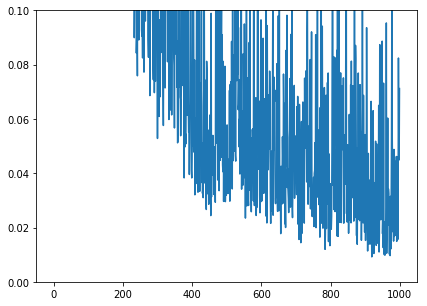

Training time: 8.55 min


In [6]:
print("Start training...")
t = time()
for i in range(MAX_ITER):
    train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=True, prefetch=0)
    interactive_plot([train_pp.get_variable('loss_history')])
    
print("Training time: {:4.2f} min".format((time() - t)/60))

Create test pipeline for segmentation images with multiple MNIST digits in random locations.

In [7]:
test_template = (Pipeline()
                 .normalize_images()
                 .make_masks()
                 .import_model('conv', train_pp)
                 .init_variable('predicted_proba', init_on_each_run=list)
                 .init_variable('predicted_labels', init_on_each_run=list)
                 .predict_model('conv', fetches=['proba', 'labels'],
                               feed_dict={'images': B('images'),
                                          'masks': B('masks')},
                               save_to=[V('predicted_proba'), V('predicted_labels')], mode='a'))

test_ppl = (test_template << mnist.test)

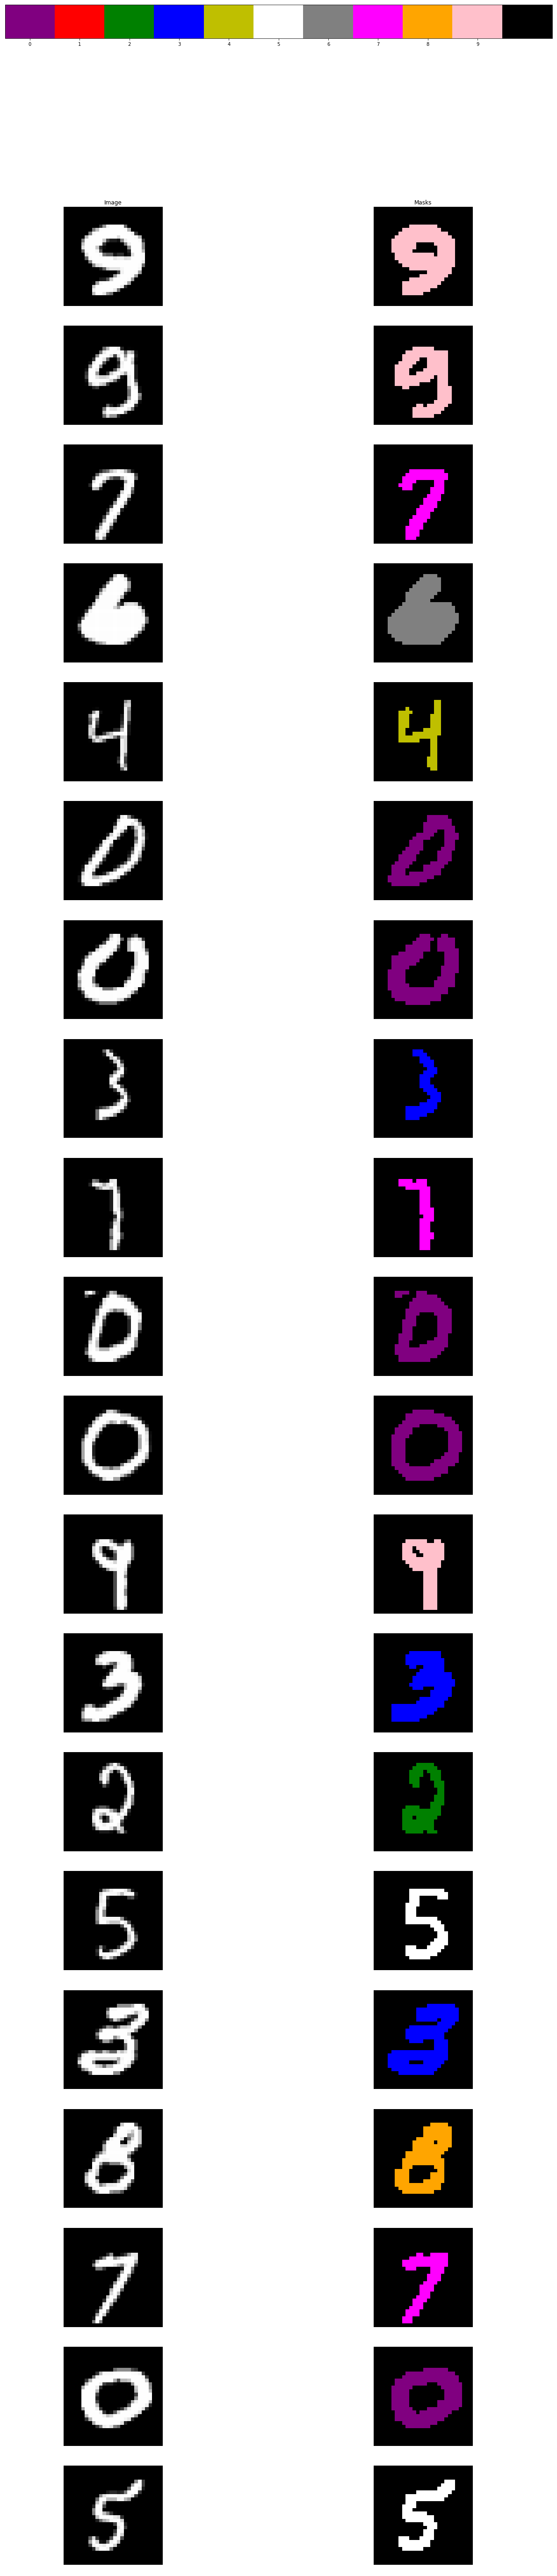

In [8]:
get_plots(test_ppl, mode='c', inverse=True, n_examples=20, batch_size=64)

Now let's demonstrate result for other segmentation networks.

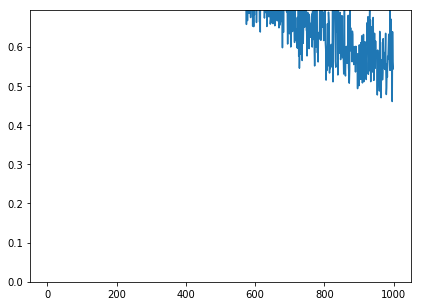

Training time: 13.80 min


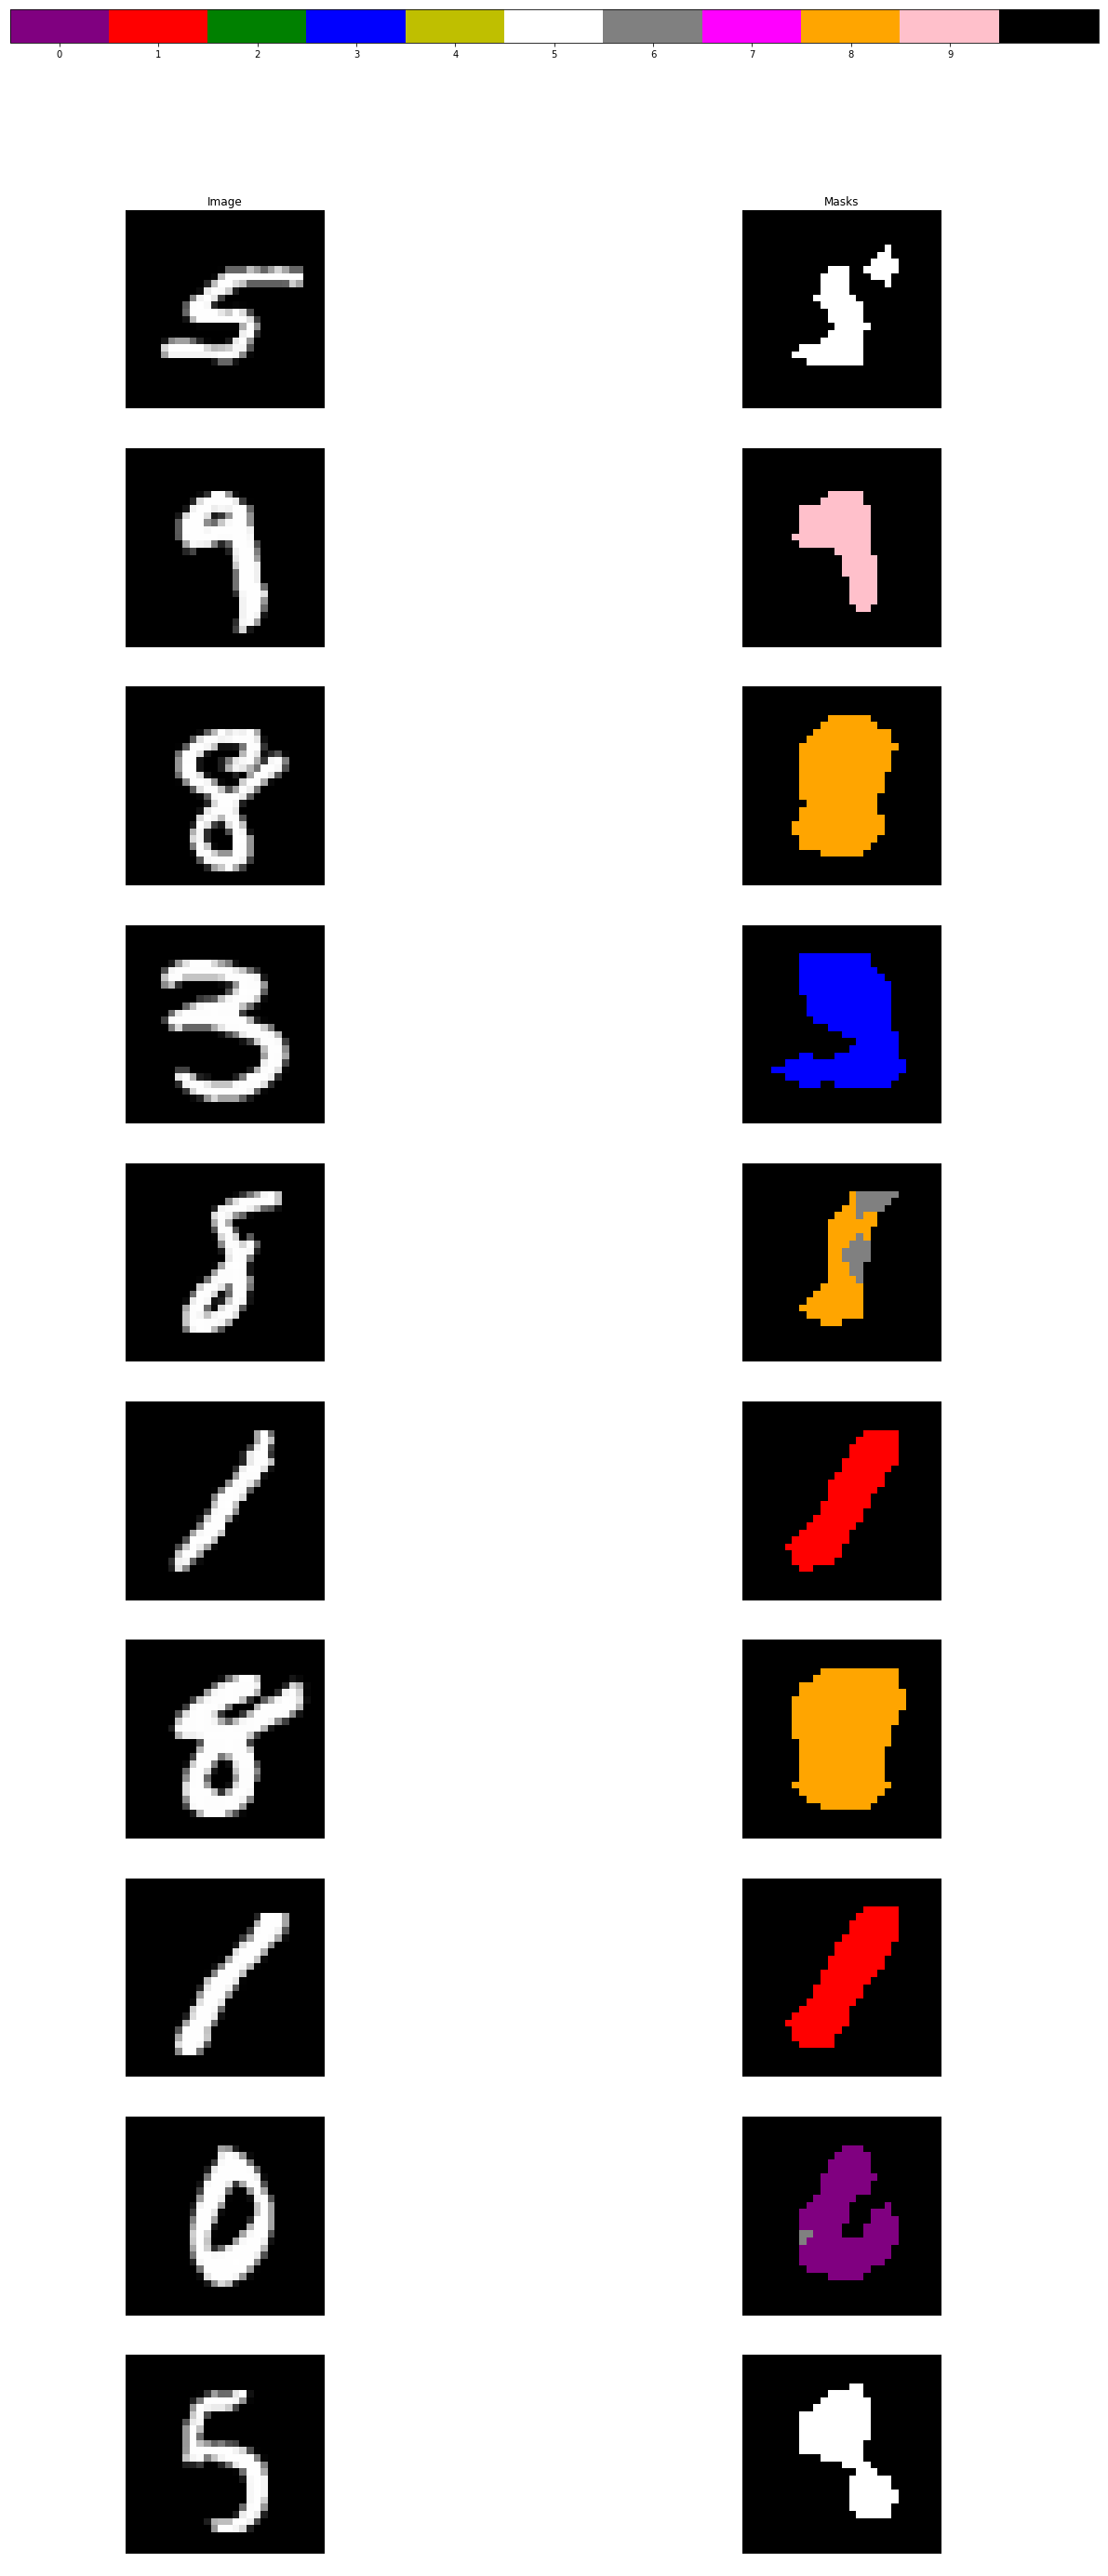

In [9]:
demonstrate_model(RefineNet, max_iter=MAX_ITER)

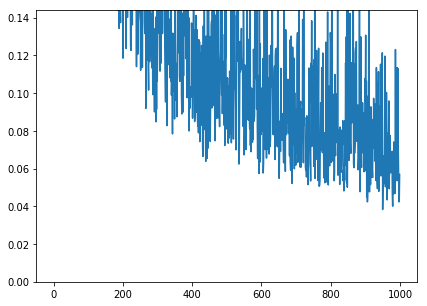

Training time: 6.93 min


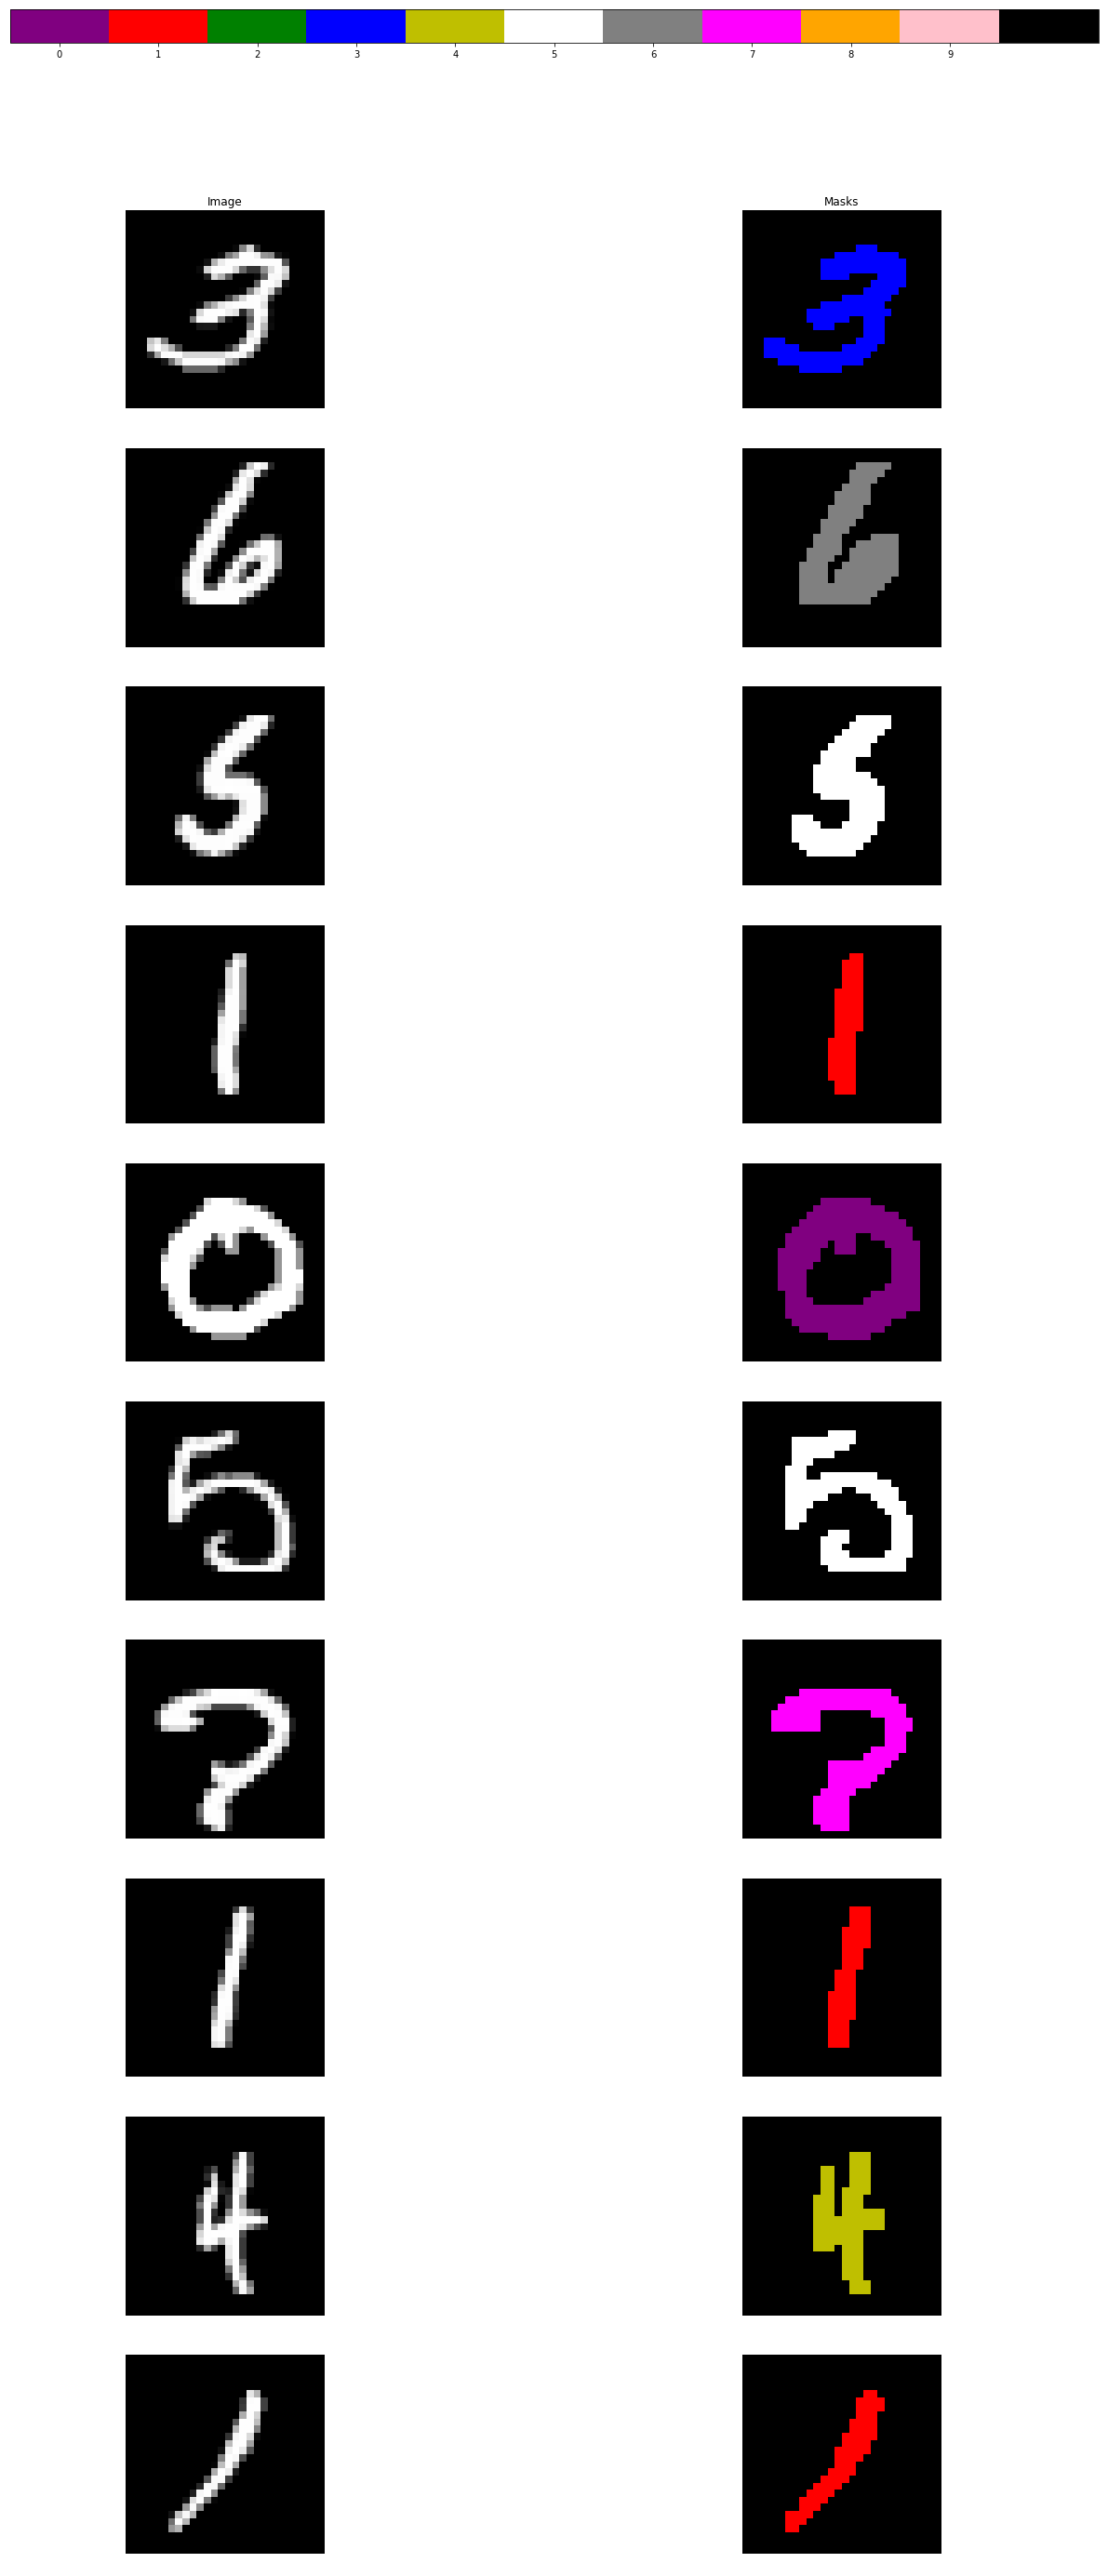

In [10]:
demonstrate_model(VNet, max_iter=MAX_ITER)

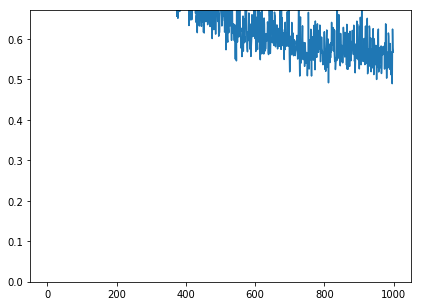

Training time: 6.27 min


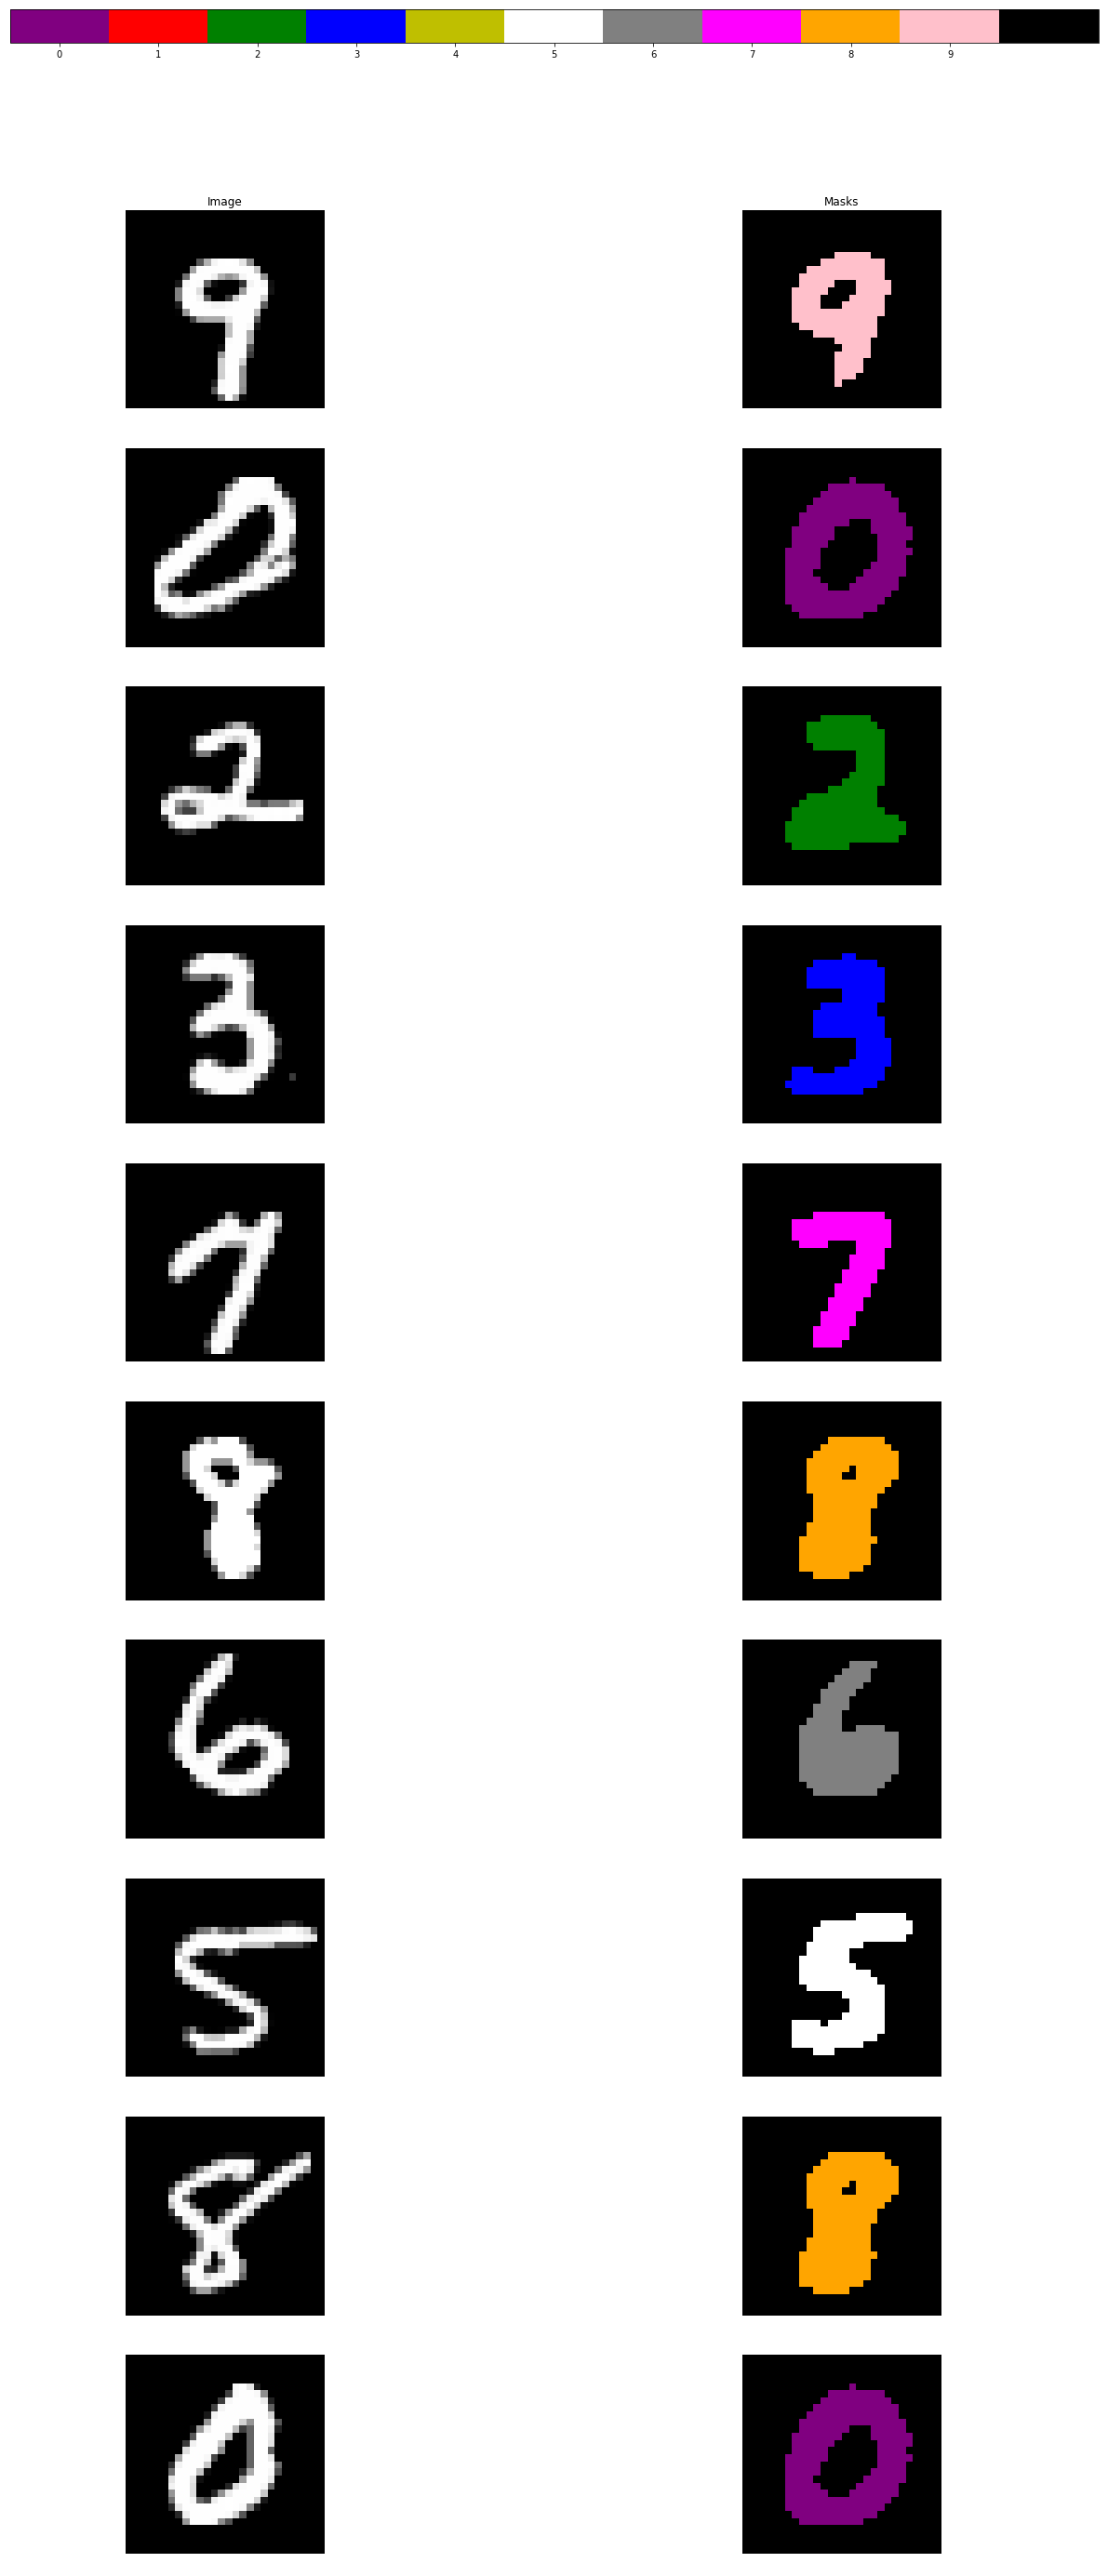

In [11]:
demonstrate_model(FCN32, max_iter=MAX_ITER)

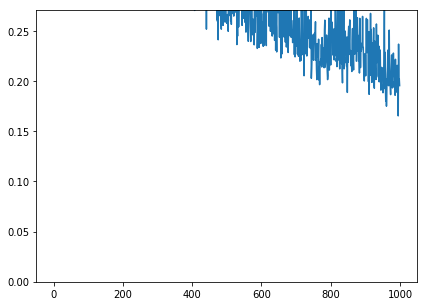

Training time: 5.61 min


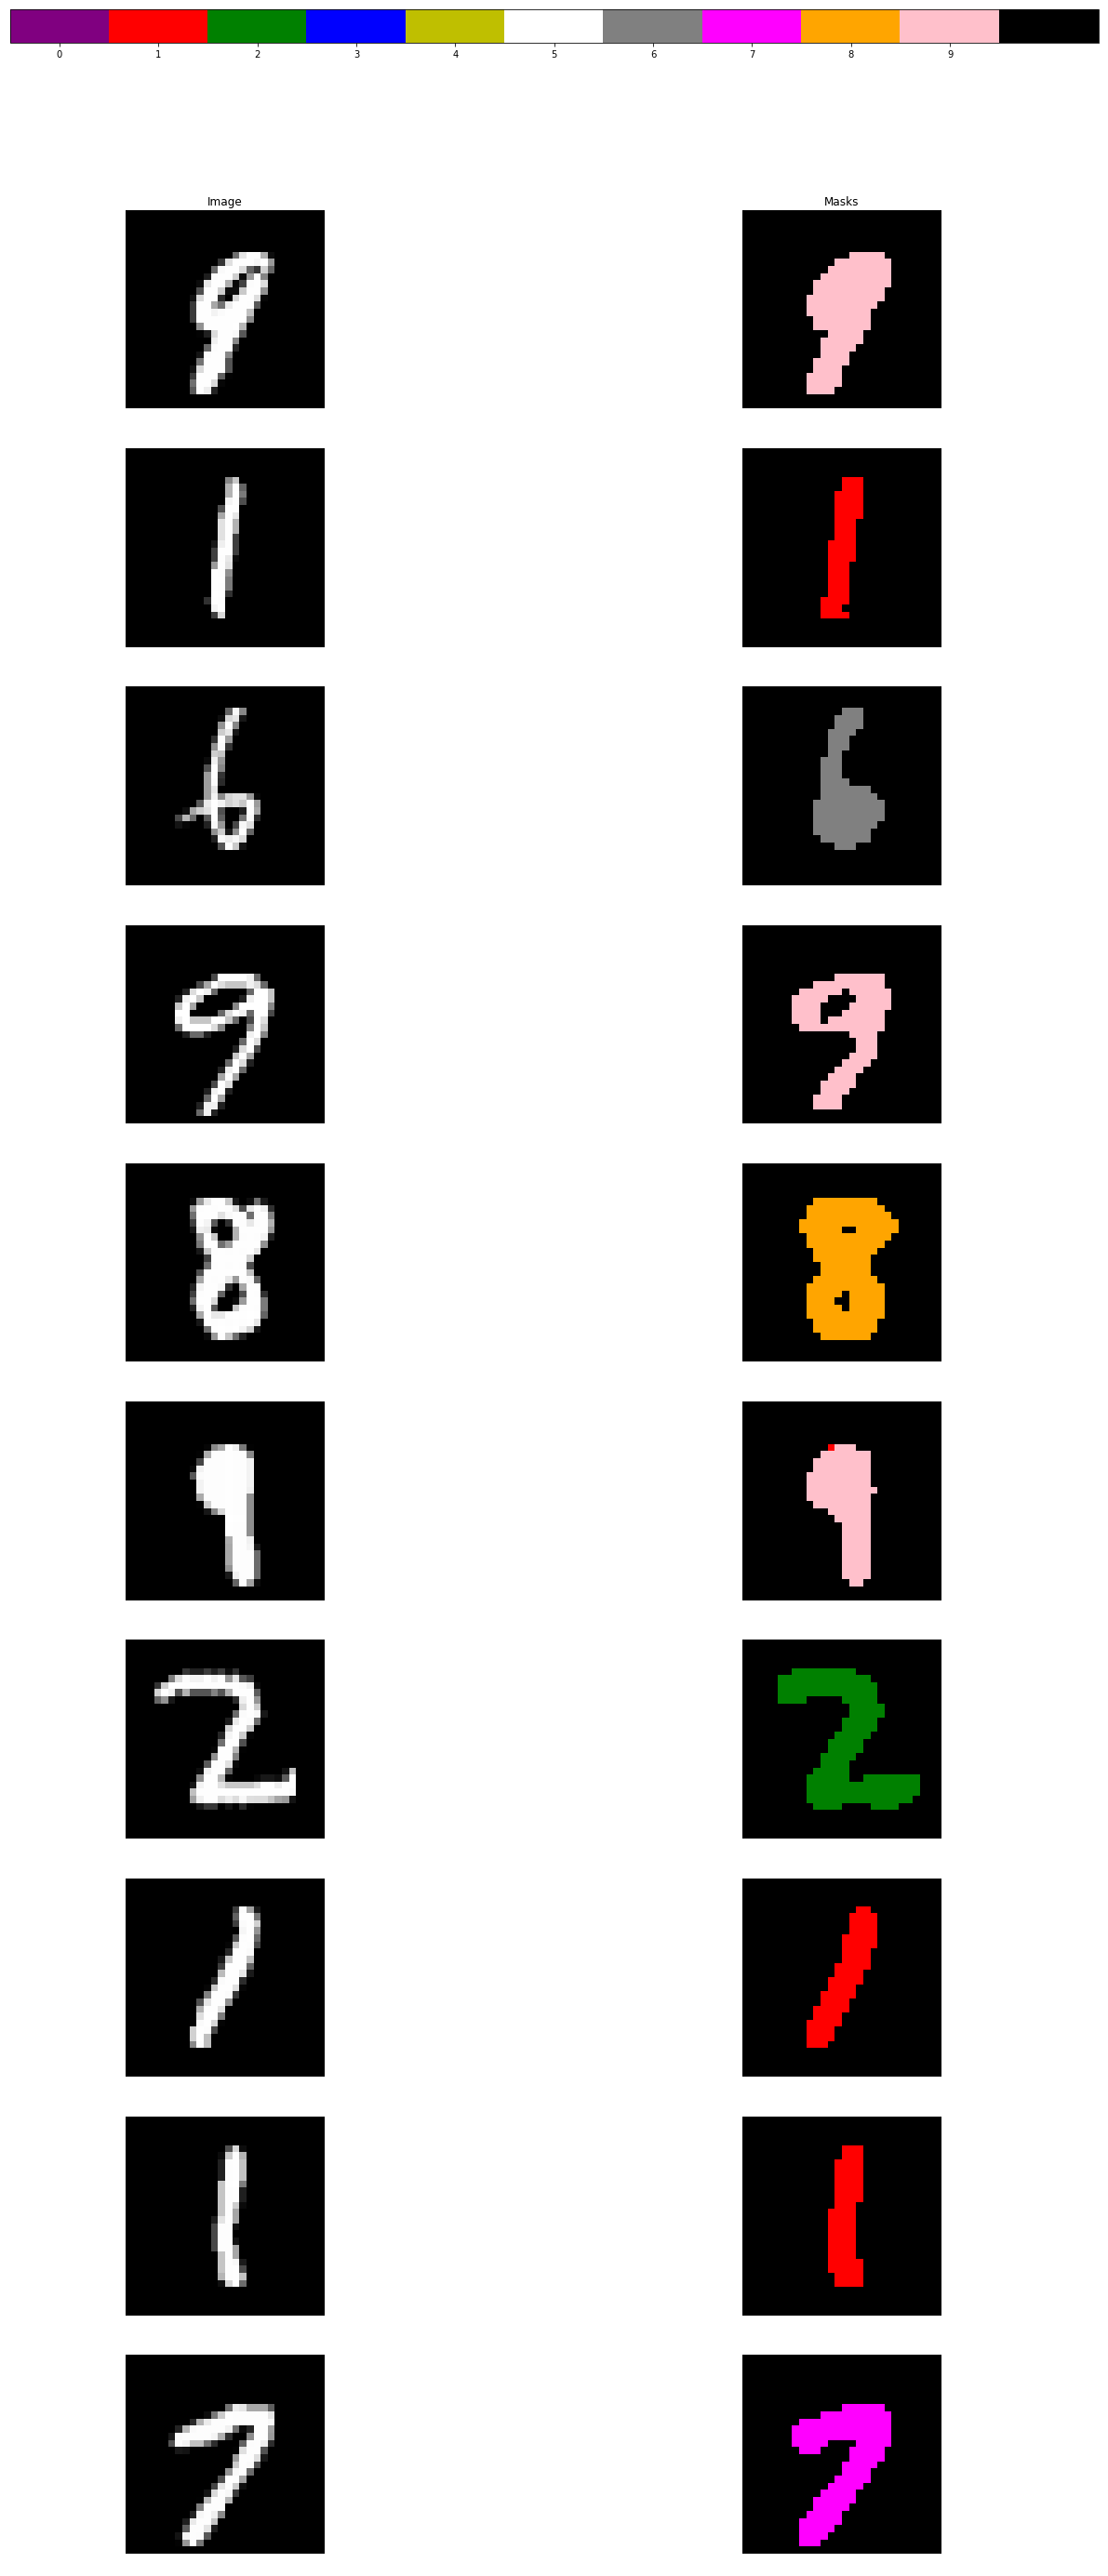

In [12]:
demonstrate_model(FCN16, max_iter=MAX_ITER)

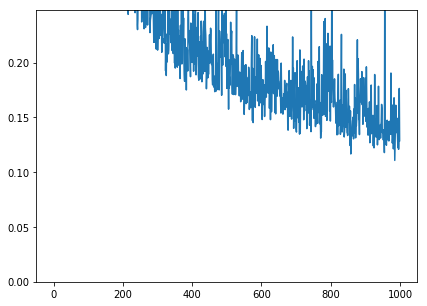

Training time: 5.56 min


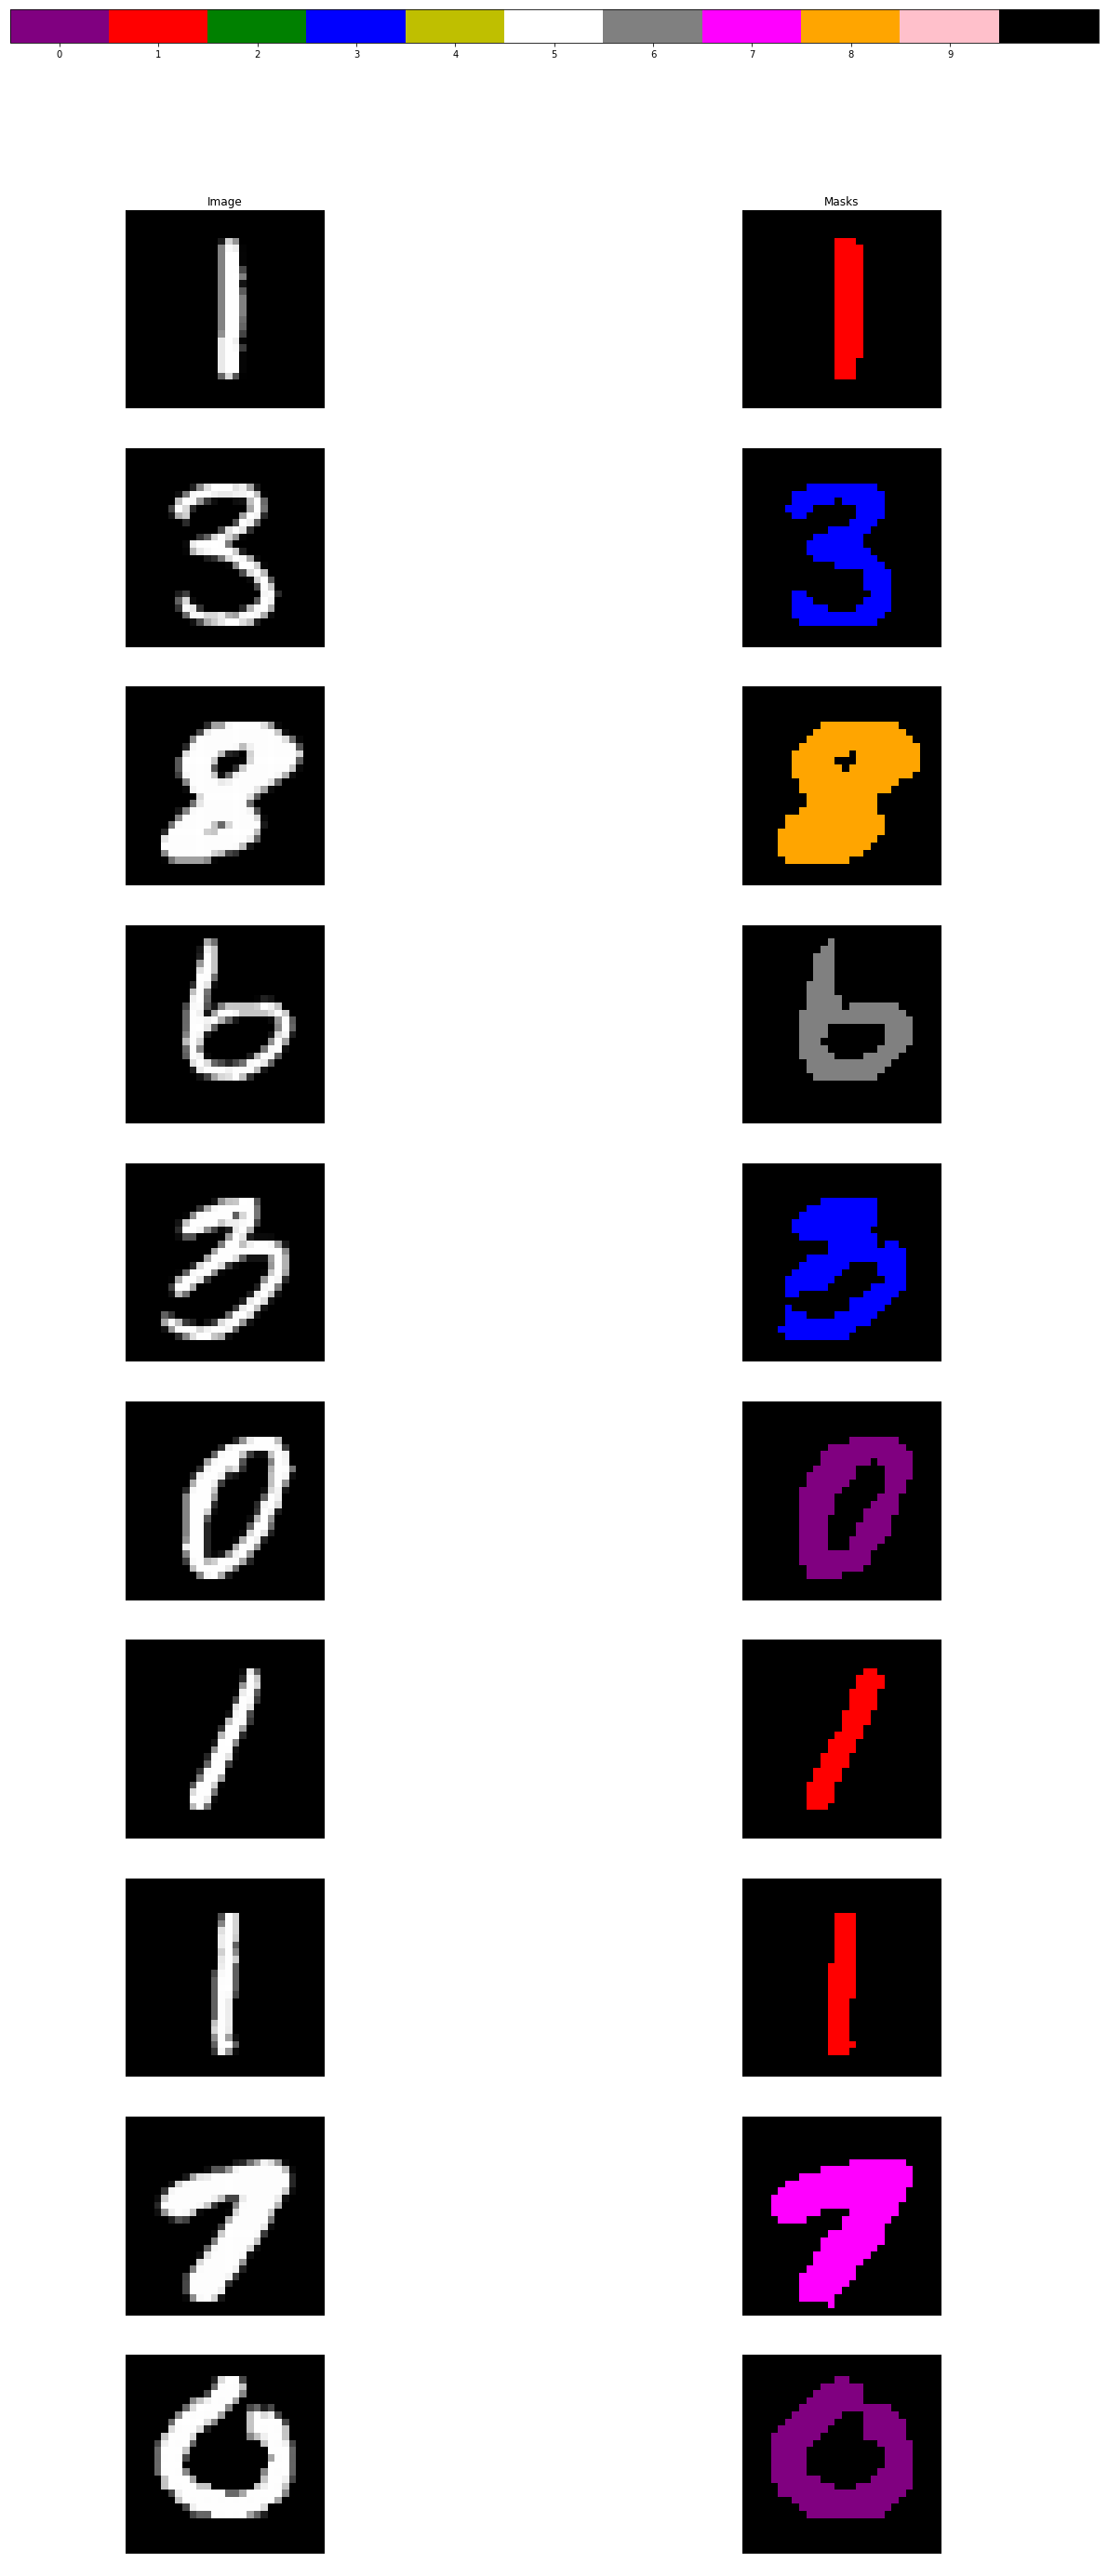

In [13]:
demonstrate_model(FCN8, max_iter=MAX_ITER)

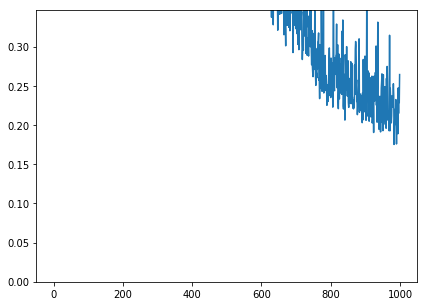

Training time: 4.89 min


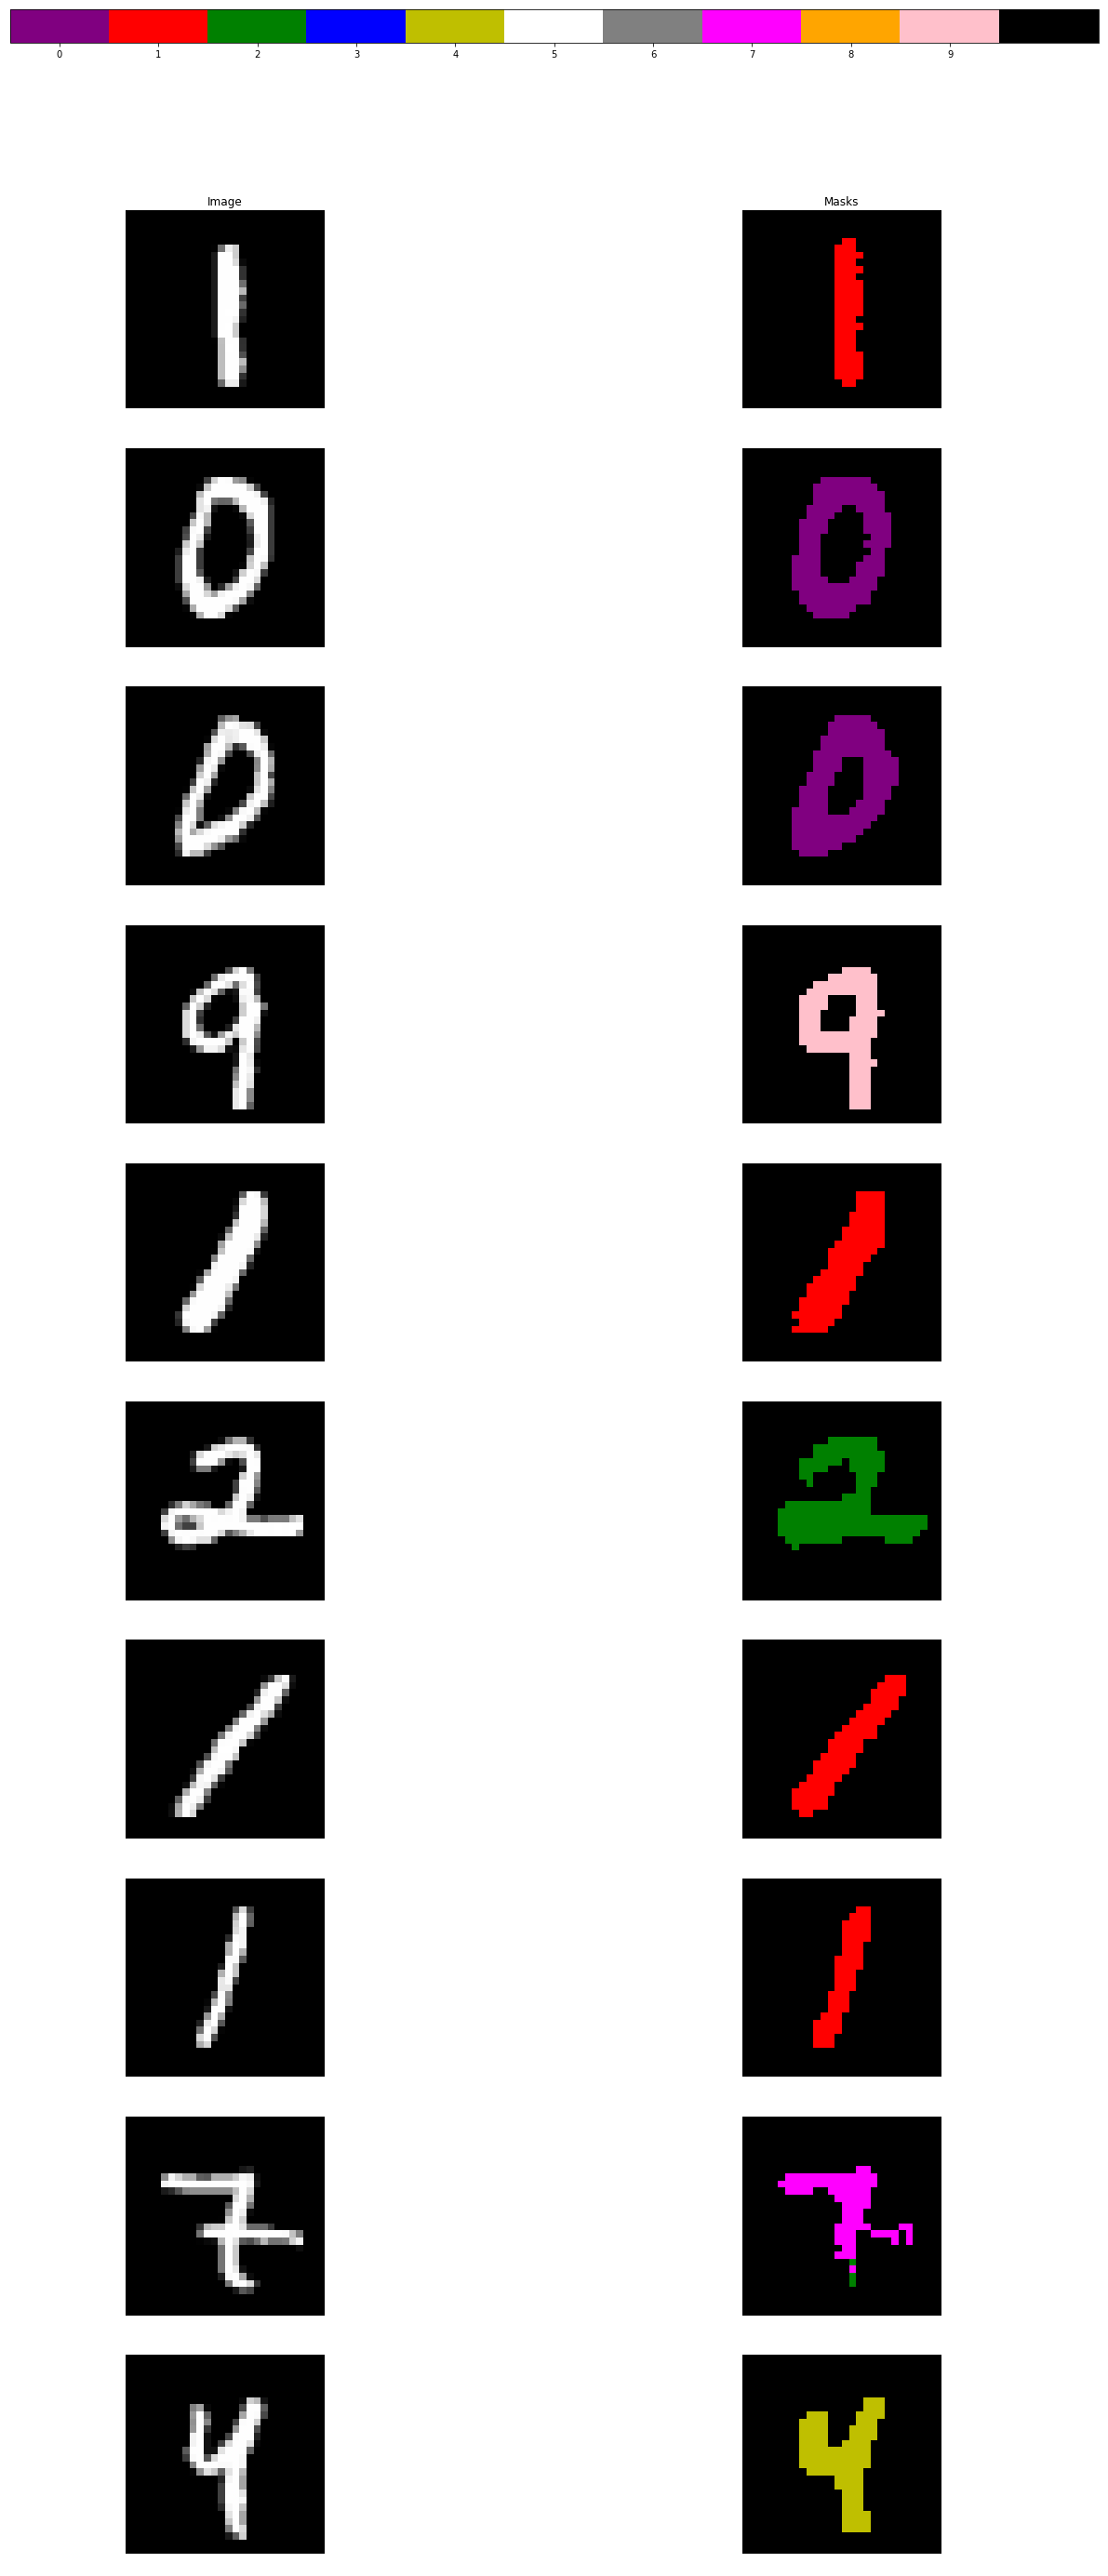

In [14]:
demonstrate_model(LinkNet, filters=128, max_iter=MAX_ITER)